In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import pandas as pd
import os
from torchvision.models import efficientnet_b2
import timm
import matplotlib.pyplot as plt
import numpy as np
import cv2
import time
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.model_selection import train_test_split
import json

In [2]:
%config Completer.use_jedi = False

In [3]:
df = pd.read_csv("/kaggle/input/dataset-normalis-patients-labels-rayon-x/DB_patients_norm_bbox.csv")
df

,Unnamed: 0,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],...,Emphysema,Fibrosis,Pleural_Thickening,Hernia,No Finding,Image Path,x,y,w,h
0,0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,...,0,0,0,0,0,/kaggle/input/data/images_001/images/00000001_...,False,False,False,False
1,1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,...,1,0,0,0,0,/kaggle/input/data/images_001/images/00000001_...,False,False,False,False
2,2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,...,0,0,0,0,0,/kaggle/input/data/images_001/images/00000001_...,False,False,False,False
3,3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,...,0,0,0,0,1,/kaggle/input/data/images_001/images/00000002_...,False,False,False,False
4,4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,...,0,0,0,1,0,/kaggle/input/data/images_001/images/00000003_...,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112115,112115,00030801_001.png,Mass|Pneumonia,1,30801,39,M,PA,2048,2500,...,0,0,0,0,0,/kaggle/input/data/images_012/images/00030801_...,False,False,False,False
112116,112116,00030802_000.png,No Finding,0,30802,29,M,PA,2048,2500,...,0,0,0,0,1,/kaggle/input/data/images_012/images/00030802_...,False,False,False,False
112117,112117,00030803_000.png,No Finding,0,30803,42,F,PA,2048,2500,...,0,0,0,0,1,/kaggle/input/data/images_012/images/00030803_...,False,False,False,False
112118,112118,00030804_000.png,No Finding,0,30804,30,F,PA,2048,2500,...,0,0,0,0,1,/kaggle/input/data/images_012/images/00030804_...,False,False,False,False


In [4]:
def filtrer_df_maladie_unique(df, col_cible, cols_zero):
    """
    Retourne les lignes du DataFrame où :
    - col_cible == 1
    - toutes les colonnes de cols_zero == 0
    """
    condition_1 = df[col_cible] == 1
    condition_0 = df[cols_zero].sum(axis=1) == 0
    return df[condition_1 & condition_0]

maladies_exclues = [
    'Atelectasis', 'Cardiomegaly', 'Effusion',  'Mass',
    'Nodule', 'Pneumonia', 'Pneumothorax', 'Consolidation', 'Edema',
    'Emphysema', 'Fibrosis', 'Pleural_Thickening', 'Hernia'
]
infiltration = filtrer_df_maladie_unique(df, "Infiltration", maladies_exclues)
infiltration.shape

maladies_exclues.append('Infiltration')
no_finding = filtrer_df_maladie_unique(df, 'No Finding', maladies_exclues)
no_finding = no_finding.sample(n=min(len(no_finding), len(infiltration)), random_state=42)
no_finding.shape

df_final = pd.concat([infiltration, no_finding])
df_final = df_final[df_final["View Position"] == "PA"]
df_final.shape
df_final["Finding Labels"].value_counts()

Finding Labels
No Finding      6213
Infiltration    5270
Name: count, dtype: int64

In [5]:
# 1. Dataset PyTorch multi-label
class ChestXrayMultilabelDataset(Dataset):
    def __init__(self, dataframe, label_cols, transform=None):
        self.df = dataframe
        self.label_cols = label_cols
        if transform is None:
            self.transform = transforms.Compose([
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
            ])
        else:
            self.transform = transform    

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image = Image.open(row['Image Path']).convert('RGB')
        if self.transform:
            image = self.transform(image)
        labels = torch.tensor(row[self.label_cols].astype(np.float32).values, dtype=torch.float32)
        return image, labels

    def __afficher_image__(self, idx):
        """
        Affiche l'image (dénormalisée) et ses labels associés.
        """
        image, label = self[idx]

        # # Dénormalisation
        mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
        std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
        image = image * std + mean  # Inverser la normalisation

        # Passage à la forme (H, W, C) pour matplotlib
        image = image.permute(1, 2, 0).clamp(0, 1)

        # Affichage
        plt.imshow(image)
        plt.title(f"Label: {label}")
        plt.axis('off')
        plt.show()

        # Affichage des maladies détectées
        nb_maladie = 0
        for i in range(len(label)):
            if label[i] == 1:
                print("Maladies présentes :")
                print(f" - {self.label_cols[i]}")
                nb_maladie += 1
        if(nb_maladie == 0):
            print("Aucune maladie")

In [6]:
transform = transforms.Compose([
    transforms.Resize((260, 260)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# 2. Préparation des données
label_columns = ['Infiltration']

train_df, val_df = train_test_split(df_final, test_size=0.2, random_state=42)


train_dataset = ChestXrayMultilabelDataset(train_df, label_columns, transform)
val_dataset = ChestXrayMultilabelDataset(val_df, label_columns, transform)


train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [7]:
# 3. Modèle EfficientNet-B2
model = efficientnet_b2(pretrained=True)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, len(label_columns))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B2_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-c35c1473.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-c35c1473.pth
100%|██████████| 35.2M/35.2M [00:00<00:00, 154MB/s]


In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tqdm import tqdm
import time
import matplotlib.pyplot as plt
import json

# 🔧 Critère et optimiseur
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# 🔁 Suivi
train_losses = []
val_losses = []
best_val_loss = float('inf')
best_model_path = "best_model.pth"

start_time = time.time()

for epoch in range(7):
    print(f"\n🟢 Epoch {epoch+1}")

    ### 🔁 Entraînement ###
    model.train()
    epoch_loss = 0
    all_preds, all_labels = [], []

    pbar = tqdm(train_loader, desc="Train", leave=False)
    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

        preds = (torch.sigmoid(outputs).detach().cpu().numpy() > 0.5).astype(int)
        all_preds.extend(preds)
        all_labels.extend(labels.cpu().numpy())

        pbar.set_postfix(loss=loss.item())

    avg_train_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    acc = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds, zero_division=0)
    rec = recall_score(all_labels, all_preds, zero_division=0)
    f1 = f1_score(all_labels, all_preds, zero_division=0)

    print(f"🔧 Train Loss: {avg_train_loss:.4f} | Acc: {acc:.4f} | Prec: {prec:.4f} | Recall: {rec:.4f} | F1: {f1:.4f}")

    ### 🧪 Validation ###
    model.eval()
    val_epoch_loss = 0
    val_preds, val_labels = [], []

    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc="Val", leave=False):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_epoch_loss += loss.item()

            preds = (torch.sigmoid(outputs).cpu().numpy() > 0.5).astype(int)
            val_preds.extend(preds)
            val_labels.extend(labels.cpu().numpy())

    avg_val_loss = val_epoch_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    acc = accuracy_score(val_labels, val_preds)
    prec = precision_score(val_labels, val_preds, zero_division=0)
    rec = recall_score(val_labels, val_preds, zero_division=0)
    f1 = f1_score(val_labels, val_preds, zero_division=0)

    print(f"🧪 Val   Loss: {avg_val_loss:.4f} | Acc: {acc:.4f} | Prec: {prec:.4f} | Recall: {rec:.4f} | F1: {f1:.4f}")

    # 💾 Sauvegarde du meilleur modèle
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), best_model_path)
        
        best_metrics = {
            "epoch": epoch + 1,
            "val_loss": avg_val_loss,
            "accuracy": acc,
            "precision": prec,
            "recall": rec,
            "f1_score": f1
        }
        
        print(f"✅ Modèle sauvegardé (val_loss = {best_val_loss:.4f})")
    
    # 💾 Sauvegarde des métriques à chaque époque (toutes les losses)
    metrics = {
        "train_loss": train_losses,
        "val_loss": val_losses,
        "best_val_loss": best_val_loss
    }
    
    with open("/kaggle/working/training_metrics.json", "w") as f:
        json.dump(metrics, f, indent=4)

end_time = time.time()
print(f"\n⏱️ Temps total d'entraînement : {end_time - start_time:.2f} secondes")

with open("/kaggle/working/best_model_metrics.json", "w") as f:
    json.dump(best_metrics, f, indent=4)


🟢 Epoch 1


🔧 Train Loss: 0.6787 | Acc: 0.5444 | Prec: 0.4987 | Recall: 0.4262 | F1: 0.4597


🧪 Val   Loss: 0.6705 | Acc: 0.5590 | Prec: 0.5593 | Recall: 0.3492 | F1: 0.4299
✅ Modèle sauvegardé (val_loss = 0.6705)

🟢 Epoch 2


🔧 Train Loss: 0.6628 | Acc: 0.5771 | Prec: 0.5375 | Recall: 0.4998 | F1: 0.5179


🧪 Val   Loss: 0.6636 | Acc: 0.5651 | Prec: 0.5652 | Recall: 0.3766 | F1: 0.4520
✅ Modèle sauvegardé (val_loss = 0.6636)

🟢 Epoch 3


🔧 Train Loss: 0.6478 | Acc: 0.6031 | Prec: 0.5658 | Recall: 0.5460 | F1: 0.5557


🧪 Val   Loss: 0.6606 | Acc: 0.5777 | Prec: 0.5723 | Recall: 0.4488 | F1: 0.5031
✅ Modèle sauvegardé (val_loss = 0.6606)

🟢 Epoch 4


🔧 Train Loss: 0.6300 | Acc: 0.6260 | Prec: 0.5896 | Recall: 0.5831 | F1: 0.5863


🧪 Val   Loss: 0.6700 | Acc: 0.5842 | Prec: 0.5956 | Recall: 0.3958 | F1: 0.4756

🟢 Epoch 5


🔧 Train Loss: 0.6106 | Acc: 0.6560 | Prec: 0.6244 | Recall: 0.6106 | F1: 0.6174


🧪 Val   Loss: 0.6555 | Acc: 0.6165 | Prec: 0.6011 | Recall: 0.5786 | F1: 0.5897
✅ Modèle sauvegardé (val_loss = 0.6555)

🟢 Epoch 6


🔧 Train Loss: 0.5837 | Acc: 0.6828 | Prec: 0.6526 | Recall: 0.6463 | F1: 0.6494


🧪 Val   Loss: 0.6815 | Acc: 0.6077 | Prec: 0.5759 | Recall: 0.6691 | F1: 0.6190

🟢 Epoch 7


🔧 Train Loss: 0.5569 | Acc: 0.7083 | Prec: 0.6794 | Recall: 0.6784 | F1: 0.6789


🧪 Val   Loss: 0.7169 | Acc: 0.5908 | Prec: 0.5841 | Recall: 0.4890 | F1: 0.5323

⏱️ Temps total d'entraînement : 2385.27 secondes


In [10]:
torch.save(model.state_dict(), "/kaggle/working/b2_infiltration_pa.pt")

📊 Résultats du modèle :

train_loss (évolution) :
  →  [0.6787, 0.6628, 0.6478, 0.63, 0.6106, 0.5837, 0.5569]
val_loss (évolution) :
  →  [0.6705, 0.6636, 0.6606, 0.67, 0.6555, 0.6815, 0.7169]
Best_val_loss : 0.6555


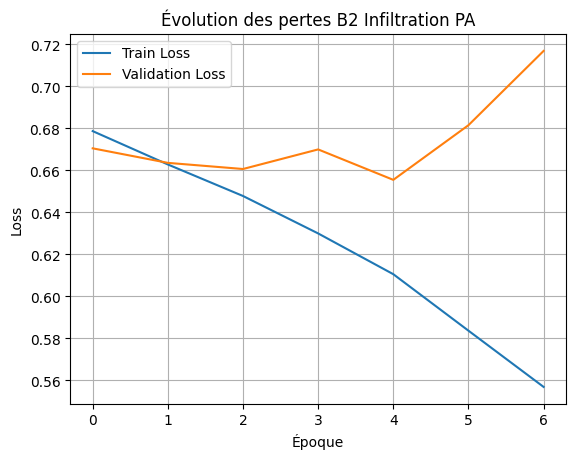

In [11]:
def afficher_metrics_json(nom):
    with open(nom, "r") as f:
        metrics = json.load(f)
    
    print("📊 Résultats du modèle :\n")
    
    for key, value in metrics.items():
        if isinstance(value, list):
            print(f"{key} (évolution) :")
            print("  → ", [round(v, 4) for v in value])
        else:
            print(f"{key.capitalize()} : {round(value, 4)}")
    
    if "train_loss" in metrics and "val_loss" in metrics:
        plt.plot(metrics["train_loss"], label="Train Loss")
        plt.plot(metrics["val_loss"], label="Validation Loss")
        plt.xlabel("Époque")
        plt.ylabel("Loss")
        plt.title("Évolution des pertes B2 Infiltration PA")
        plt.legend()
        plt.grid(True)
        plt.show()
afficher_metrics_json("/kaggle/working/training_metrics.json")